In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from func.MonteCarloFom import pickleread
from func.fom_optimize import findbestshift
from func.MonteCarloFom_Origin import SetAlign
from func.Classes import Array2d
from func.GravLens import Lens, get_shear, get_galaxies
(dataA,sigmaA,maskA,maskANull,dataB1,sigmaB1,dataB2,sigmaB2,dataB3,sigmaB3,dataC,sigmaC,dataD,sigmaD,maskD,maskDNull,dataE,sigmaE,sumsim,xraysim1,xraysim2,xraysim3,szsim)=pickleread()
theta =  1.08 
psi = 3.03 
phi = 0
Mask = (1,1,0,0,0)
ConstrainPhi = False
MaxShift = 0
tol=1.0E-7 
data1list=list((sumsim,xraysim1))
data2list=list((dataA,dataB1))
sigmalist=list((sigmaA,sigmaB1))
if Mask[1] == 1:
    masklist=list((maskA,maskA))
else:
    masklist=list((maskA,maskANull))

numarrays = len(data1list)
shifteddata1list=list()
for i in range(numarrays):
    shifteddata1list.append(Array2d(data2list[i].xmin,data2list[i].xmax,data2list[i].nx,data2list[i].ymin,data2list[i].ymax,data2list[i].ny))

align = SetAlign(dataB1, phi, theta, psi, ConstrainPhi=ConstrainPhi, MaxShift=MaxShift)
shear = get_shear()
galaxies = get_galaxies()
lens = Lens(sumsim)




# (func,f_eval,accept_rate) =findbestshift(data1list, data2list, shifteddata1list,sigmalist, masklist, align, tol)
# phi = func.align.d[4] 
# fom = func.images_align.fom[0]
# xfom = func.images_align.fom[1]

# print (fom, xfom, phi)
# print f_eval
# print accept_rate

/Users/yhhsu/Anaconda/anaconda/envs/sim3/lib/python2.7/site-packages/matplotlib/cbook.py:133: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/yhhsu/Anaconda/anaconda/envs/sim3/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [40]:
align.d[4]

3.4143598282103498

In [28]:
class Lens:
    def __init__(self,mass):
        self.mass = mass
        self.kappa = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self.potiential = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self.alpha = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self.alphaX = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self.alphaY = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self.gamma = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self.gamma1 = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self.gamma2 = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self.mag = Array2d(mass.xmin,mass.xmax,mass.nx,mass.ymin,mass.ymax,mass.ny)
        self._findvalue_by_potential(mass)
    def _findvalue_by_potential(self,mass):
        # faster ~47s for 220x220
        sigmacr = 0.3963
        ds = mass.dx * mass.dy
        MassFactor = BulletConstants.cm_per_kpc**2 * ds / (BulletConstants.g_per_Msun * 1E10)
        _kappa = mass.data/sigmacr/MassFactor
        [y_grid,x_grid] = np.meshgrid(mass.y,mass.x)
        x_grid = x_grid/4.413
        y_grid = y_grid/4.413
        _potential = np.zeros((mass.nx,mass.ny))
        _gamma1 = np.zeros((mass.nx,mass.ny))
        _gamma2 = np.zeros((mass.nx,mass.ny))
        for i in range(mass.nx):
            for j in range(mass.ny):
                dx = x_grid[i,j] - x_grid
                dy = y_grid[i,j] - y_grid
                _potential[i,j] = _kappa[i,j]*np.ma.log(np.sqrt(dx*dx+dy*dy)).sum()
        _potential = _potential/np.pi
        p2a = 2*mass.xmax/4.413/mass.nx
        _alphaX, _alphaY = np.gradient(_potential,p2a) #unit = "
        _alpha = np.sqrt(_alphaX**2 + _alphaY**2)
        domi = 1.
        k = self._extend_matrix(_potential)
        _gamma1[:,:] = 0.5*((k[2:,1:-1]-2.*k[1:-1,1:-1]+k[0:-2,1:-1])/domi**2 - (k[1:-1,2:]-2.*k[1:-1,1:-1]+k[1:-1,0:-2])/domi**2)
        _gamma2[:,:] =(k[2:,2:]-k[2:,0:-2]-k[0:-2,2:]+k[0:-2,0:-2])/4./domi**2
        _gamma = np.sqrt(_gamma1**2 + _gamma2**2)
        _mag = (1.-_kappa)**2 - _gamma**2
        self.kappa.data = _kappa
        self.potiential.data = _potential
        self.alpha.data = _alpha
        self.alphaX.data = _alphaX
        self.alphaY.data = _alphaY
        self.gamma.data = _gamma
        self.gamma1.data = _gamma1
        self.gamma2.data = _gamma2
        self.mag.data = _mag
    def _findvalue_by_mass(self,mass):
        # ~70s for 220x220
        sigmacr = 0.3963
        ds = mass.dx * mass.dy
        MassFactor = BulletConstants.cm_per_kpc**2 * ds / (BulletConstants.g_per_Msun * 1E10)
        _kappa = mass.data/sigmacr/MassFactor
        [y_grid,x_grid] = np.meshgrid(mass.y,mass.x)
        #_potiential = np.zeros((mass.nx,mass.ny))
        _alphaX = np.zeros((mass.nx,mass.ny))
        _alphaY = np.zeros((mass.nx,mass.ny))
        _gamma1 = np.zeros((mass.nx,mass.ny))
        _gamma2 = np.zeros((mass.nx,mass.ny))
        for i in range(mass.nx):
            for j in range(mass.ny):
                dx = x_grid[i,j] - x_grid
                dy = y_grid[i,j] - y_grid
                domi = (dy*dy + dx*dx)
                domi_sq = domi * domi
                d1 = (dy*dy - dx*dx)/ domi_sq
                d2 = (-2.*dx*dy)/ domi_sq
                _alphaX[i,j] = np.nansum(_kappa * dx/ domi) #unit
                _alphaY[i,j] = np.nansum(_kappa * dy/ domi)
                _gamma1[i,j] = np.nansum(_kappa*d1)
                _gamma2[i,j] = np.nansum(_kappa*d2)
        _alpha = np.sqrt(_alphaX*_alphaX + _alphaY*_alphaY)
        _gamma = np.sqrt(_gamma1**2 + _gamma2**2)
        _mag = ((1-_kappa)**2-_gamma**2)
        self.kappa.data = _kappa
        self.alpha.data = _alpha*ds/4.413/3600./180.
        self.alphaX.data = _alphaX*ds/4.413/3600./180.
        self.alphaY.data = _alphaY*ds/4.413/3600./180.
        self.gamma.data = _gamma*ds/np.pi
        self.gamma1.data = _gamma1*ds/np.pi
        self.gamma2.data = _gamma2*ds/np.pi
        _mag = ((1-_kappa)**2-_gamma**2)
        self.mag.data = _mag
    def _extend_matrix(self,p):
		nx,ny=np.shape(p)
		k=np.zeros([nx+2,ny+2])
		k[1:-1,1:-1]=p[:,:]
		k[0,1:-1]=p[-1,:]
		k[-1,1:-1]=p[0,:]
		k[1:-1,0]=p[:,-1]
		k[1:-1,-1]=p[:,0]
		return k

In [29]:
import func.BulletConstants as BulletConstants
lens = Lens(sumsim)

In [17]:
def chi_strong(x0,Lens,galaxies):
    sigma = 0.6
    chi = 0
    dx,dy,phi = x0[0]/4.413,x0[1]/4.413,x0[2]
    for key in galaxies:a
        gal = galaxies[key]
        gal.clean()
        gal.update_image(dx,dy,phi) 
        for i in range(gal.n):
            xh = gal.xc[i]
            yh = gal.yc[i]
            zf = gal.zf[i]
            xi,yi = ray_trace(xh,yh,zf,Lens.alphaX,Lens.alphaY)
            print key
            print xh,yh,xi,yi
            Mi = BiLnrIntrp(xi,yi,Lens.mag)
            gal.add_source(xi,yi)
            gal.add_mag(Mi)
        chi += sum(gal.update_chi(sigma))/gal.n
    return chi

def BiLnrIntrp(x,y,data):
    #Bilinear Interpolation 
    i = find_index(x,data.x/4.413)
    j = find_index(y,data.y/4.413)
    x1 = data.x[i]/4.413
    x2 = data.x[i+1]/4.413
    y1 = data.y[j]/4.413
    y2 = data.y[j+1]/4.413
    f11 = data.data[i,j]
    f12 = data.data[i,j+1]
    f21 = data.data[i+1,j]
    f22 = data.data[i+1,j+1]
    f = (f11*(x2-x)*(y2-y)+f21*(x-x1)*(y2-y)+f12*(x2-x)*(y-y1)+f22*(x-x1)*(y-y1))/((x2-x1)*(y2-y1))
    return f

def find_index(x,a):
    lo = 0
    hi = len(a)
    while lo<hi:
        mid = (lo+hi)//2
        if a[mid]<x:lo=mid+1
        else: hi=mid
    return lo

def ray_trace(x,y,zf,alpha_x,alpha_y):
    ax = BiLnrIntrp(x,y,alpha_x)
    ay = BiLnrIntrp(x,y,alpha_y)
    x0 = x + zf*ax
    y0 = y + zf*ay
    return x0,y0

In [18]:
chi_strong(x0,lens,galaxies)

A
38.1599549387 66.7761603719 150.348947034 -1268.49324184
A
46.4984174308 59.7736679707 -15.8679396341 -1234.18908479
C
29.4859649474 63.1575531414 470.966749583 -1289.0978225


IndexError: index out of bounds

In [23]:
def cusp(x,y,alpha_x,alpha_y,z=3.24):
    from scipy.interpolate import splprep, splev
    x0,y0 = [],[]
    for i in range(len(x)):
        zf=Zfunc(z)
        xi,yi = ray_trace(x[i],y[i],zf,alpha_x,alpha_y)
        x0.append(xi)
        y0.append(yi)
    x0=np.array(x0)
    y0=np.array(y0)
    pts = np.array([x0[::],y0[::]])
    tck, u = splprep(pts, u=None, s=0.0, per=1) 
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)
    return x_new,y_new
def curve(ax1,x_cr,y_cr,x_cusp,y_cusp):
    cx1 = ax1.plot(np.array(x_cr),np.array(y_cr),color = "y")
    cx2 = ax1.plot(np.array(x_cusp),np.array(y_cusp),color = "r")
    return ax1

def plot_ccurve_cusp(ax1,Mag,alpha_x,alpha_y):
    [dyy,dxx] = np.meshgrid(Mag.y[10:-10]/4.413,Mag.x[10:-10]/4.413)
    levels = [0,1]
    #c1 = ax1.contour(dxx,dyy,Mag.data[10:-10,10:-10],colors = 'y',levels=levels)
    level = 0
    c1 = cntr.Cntr(dxx, dyy, Mag.data[10:-10,10:-10])
    nlist = c1.trace(level, level, 0)
    segs = nlist[:len(nlist)//2]
    x_cr,y_cr,x_cusp,y_cusp=[],[],[],[]
    for i in range(len(segs)):
        x = segs[i][:,0]
        y = segs[i][:,1]
        x1,y1 = cusp(x,y,alpha_x,alpha_y)
        ax1 = curve(ax1,x,y,x1,y1)
    return ax1
def add_SL_galaxies(ax,galaxies):
    markers = ['bo', 'gv', 'r^', 'c<', 'm>', 'y8', 'ks', 'bp', 'g*', 'rh', 'cH', 'mD', 'yd']
    if galaxies["A"].xs:
        m = 0
        for key in galaxies:
            gal = galaxies[key]
            ax.plot(gal.xc,gal.yc,markers[m],linestyle='None',markersize=6,label=key)
            ax.plot(gal.xs,gal.ys,markers[m],linestyle='None',markersize=3,label=key+'s')     
            m+=1
    else:
        m = 0
        for key in galaxies:
            gal = galaxies[key]
            ax.plot(gal.xc,gal.yc,markers[m],linestyle='None',markersize=6,label=key)   
            m+=1
    return ax   

def kappa_over(Lens,galaxies):
    title='critical curve overlap convergence'
    #SkyCoordinate
    alpha = Lens.alpha
    alpha_x = Lens.alphaX
    alpha_y = Lens.alphaY
    kappa = Lens.kappa
    Mag = Lens.mag
    fig = plt.figure(figsize=(16,10.4))
    [dyy,dxx] = np.meshgrid(alpha.y/4.413,alpha.x/4.413)
    ax1= plt.axes([0.1,0.1,0.7,0.8])
    cx1 = ax1.contour(dxx,dyy,alpha.data,colors = 'black',cmap = None,linestyles = "solid")
    cax = fig.add_axes([0.95,0.1,0.1,0.8],visible=False)
    plt.colorbar(cx1,cax=cax)
    plt.clabel(cx1,cax=cax,colors="white")
    level = np.linspace(0,3,11)
    cx2 = ax1.contourf(dxx,dyy,kappa.data,levels=level)
    for c in cx2.collections:
        c.set_linewidth(0.1)
        c.set_alpha(0.8)
    cax2 = fig.add_axes([0.85,0.1,0.02,0.8])
    plt.colorbar(cx2,cax=cax2)
    x_min = -200
    x_max = 200
    ticksrange = np.linspace(x_min,x_max,11)
    title = title
    ax1.set_title(title)
    ax1.set_xlim([x_min,x_max])
    ax1.set_ylim([x_min,x_max])
    ax1.set_xticks(ticksrange)
    ax1.set_yticks(ticksrange)
    ax1.set_xlabel("arcsec")
    ax1.set_ylabel("arcsec")
    ax1.set_xlabel("arcsec")
    ax1.set_ylabel("arcsec")
    ax1.grid(True,which="both")
    ax1 = add_SL_galaxies(ax1,galaxies)
    ax1 = plot_ccurve_cusp(ax1,Mag,alpha_x,alpha_y)
    #fig.savefig(fname)
    ax1.legend( loc='upper left')
    fig.show()

NameError: global name 'cntr' is not defined

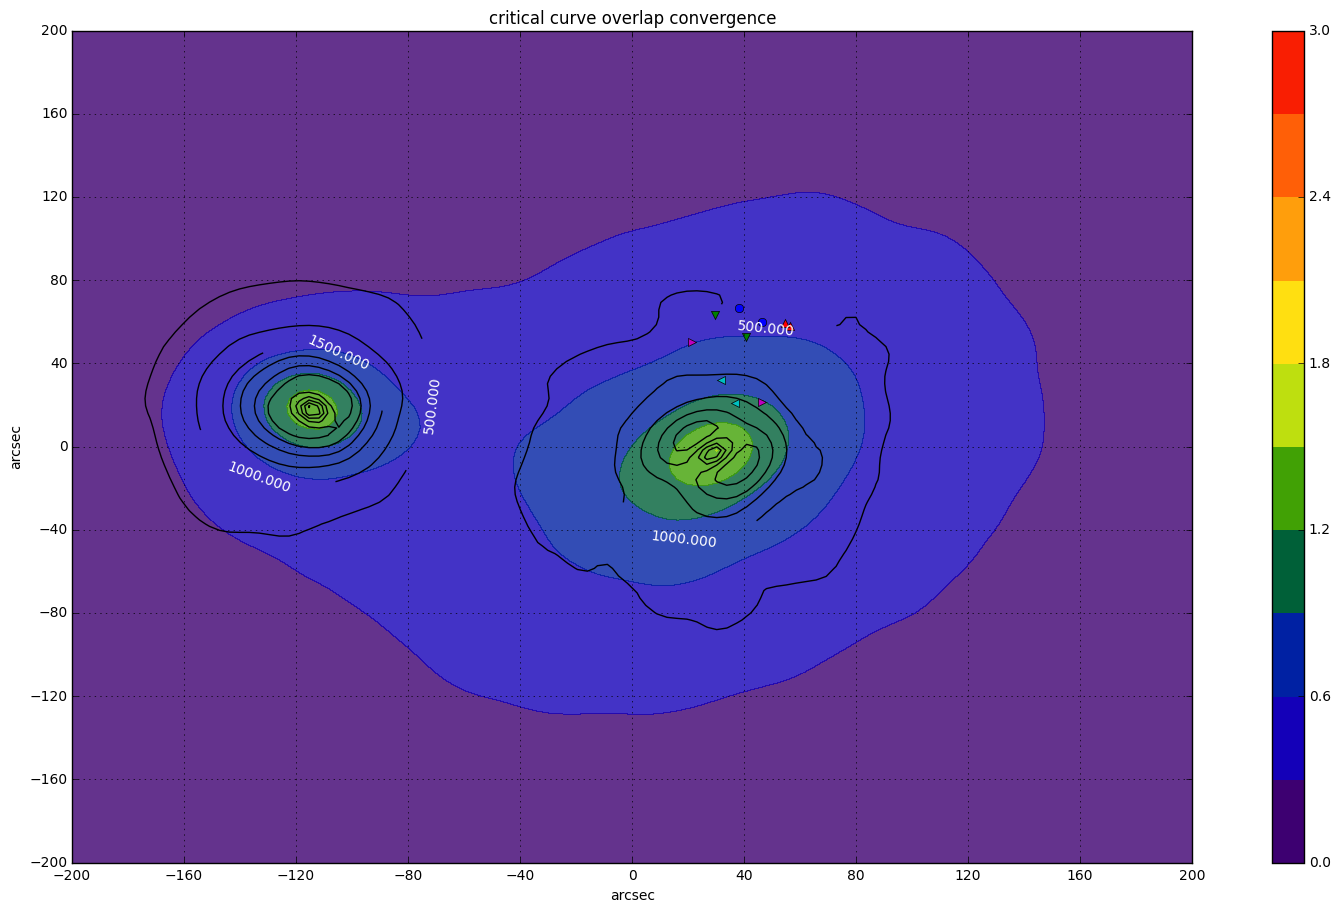

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
kappa_over(lens,galaxies)

<matplotlib.colorbar.Colorbar instance at 0x11092b7a0>

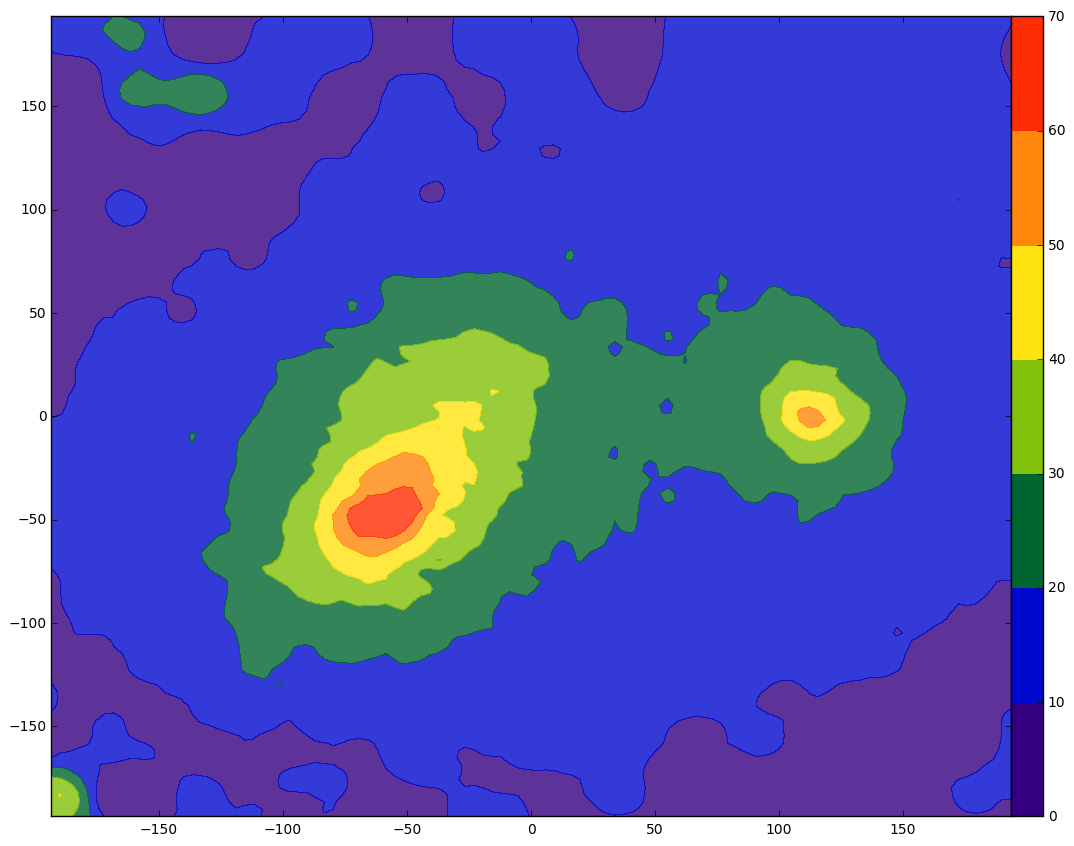

In [38]:
[dyy,dxx] = np.meshgrid(dataA.y/4.413,dataA.x/4.413)
fig = plt.figure(figsize=(16,10))
ax1 = plt.axes([0.1,0.1,0.6,0.8])
cx2 = ax1.contourf(dxx,dyy,dataA.data)
for c in cx2.collections:
    c.set_linewidth(0.1)
    c.set_alpha(0.8)
cax2 = fig.add_axes([0.7,0.1,0.02,0.8])
plt.colorbar(cx2,cax=cax2)
# level = [0,15,30,45,60,75]
# cx1 = ax1.contour(dxx,dyy,lens.alpha.data,colors='k',levels=level)
# cax1 = fig.add_axes([0.95,0.1,0.1,0.8],visible=False)
# plt.colorbar(cx1,cax=cax1)
# plt.clabel(cx1,cax=cax1,fmt='%1.1f',fontsize='small')

In [41]:
a = list()

In [42]:
a

[]